<a href="https://colab.research.google.com/github/ergul13/clustering_music/blob/main/clusterin_music_genres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
pip install catboost

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/clustering_music_genres/Spotify-2000.csv')

In [44]:
print(df.head())
print("-" * 30)
print("Veri setindeki sütunlar:")
print(df.columns)
print("-" * 30)

   Index                   Title             Artist            Top Genre  \
0      1                 Sunrise        Norah Jones      adult standards   
1      2             Black Night        Deep Purple           album rock   
2      3          Clint Eastwood           Gorillaz  alternative hip hop   
3      4           The Pretender       Foo Fighters    alternative metal   
4      5  Waitin' On A Sunny Day  Bruce Springsteen         classic rock   

   Year  Beats Per Minute (BPM)  Energy  Danceability  Loudness (dB)  \
0  2004                     157      30            53            -14   
1  2000                     135      79            50            -11   
2  2001                     168      69            66             -9   
3  2007                     173      96            43             -4   
4  2002                     106      82            58             -5   

   Liveness  Valence Length (Duration)  Acousticness  Speechiness  Popularity  \
0        11       68         

In [38]:
def genre_grouping(genre):
    # 'Top Genre' sütunundaki değerlerin string olduğundan emin olalım
    if not isinstance(genre, str):
        return 'other'

    genre = genre.lower() # Büyük/küçük harf duyarlılığını kaldırmak için
    if any(g in genre for g in ['album rock', 'alternative rock', 'hard rock', 'classic rock', 'modern rock', 'rock']):
        return 'rock'
    elif any(g in genre for g in ['pop', 'dance pop', 'dutch pop']):
        return 'pop'
    elif any(g in genre for g in ['indie', 'dutch indie']):
        return 'indie'
    else:
        return 'other'

# Gruplama fonksiyonunu uygula ve yeni bir sütun oluştur
df['Top Genre Grouped'] = df['Top Genre'].apply(genre_grouping)

# Çok az sayıda örneği olan grupları (30'dan az) veri setinden çıkar
counts = df['Top Genre Grouped'].value_counts()
df = df[df['Top Genre Grouped'].isin(counts[counts > 30].index)]

print("Veri setindeki türlerin dağılımı:")
print(df['Top Genre Grouped'].value_counts())
print("-" * 30)

Veri setindeki türlerin dağılımı:
Top Genre Grouped
rock     857
other    670
pop      388
indie     79
Name: count, dtype: int64
------------------------------


In [39]:
feature_cols = ['Danceability', 'Energy', 'Valence', 'Loudness (dB)', 'Liveness', 'Speechiness', 'Acousticness', 'Beats Per Minute (BPM)']

# Virgülle yazılmış ondalık sayıları noktaya çevirip sayısal tipe dönüştür
# Bazen bu sütunlar zaten doğru formatta olabilir, bu yüzden hata kontrolü ekleyelim
for col in feature_cols:
    if df[col].dtype == 'object': # Sadece metin tipindeyse bu işlemi yap
        df[col] = df[col].str.replace(',', '.').astype(float)


In [40]:
X = df[feature_cols]
y = df['Top Genre Grouped']

# Sayısal verileri standartlaştır (ölçeklendir)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Veriyi eğitim ve test setlerine ayır (%80 eğitim, %20 test)
# stratify=y -> Sınıf dağılımını korur
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

# Sınıf dengesizliği için ağırlıkları hesapla
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))

In [41]:
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'iterations': [500, 1000]
}

# GridSearchCV için temel CatBoost modelini oluştur
# verbose=0 -> Arama sırasında her adımı yazdırmaz, ekranı temiz tutar
model_for_grid = CatBoostClassifier(random_seed=42, verbose=0, class_weights=class_weights_dict)

# GridSearchCV'ü ayarla
# cv=StratifiedKFold(n_splits=3) -> Sınıf dağılımını koruyan 3 katlı çapraz doğrulama
# scoring='f1_weighted' -> F1 skoruna göre en iyi modeli seç (dengesiz sınıflar için iyi bir metrik)
# n_jobs=-1 -> Bilgisayarındaki tüm işlemci çekirdeklerini kullanarak aramayı hızlandırır
grid_search = GridSearchCV(
    estimator=model_for_grid,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1,
    scoring='f1_weighted'
)

print("Hiperparametre optimizasyonu başlıyor... (Bu işlem biraz zaman alabilir)")
# GridSearchCV'ü eğitim verisiyle çalıştır
grid_search.fit(X_train, y_train)

# En iyi sonuçları ve parametreleri al
print("Optimizasyon tamamlandı!")
print("-" * 30)
print("Bulunan en iyi parametreler:", grid_search.best_params_)
print("En iyi F1 skoru (Çapraz Doğrulama ile):", f"{grid_search.best_score_:.4f}")
print("-" * 30)


Hiperparametre optimizasyonu başlıyor... (Bu işlem biraz zaman alabilir)
Optimizasyon tamamlandı!
------------------------------
Bulunan en iyi parametreler: {'depth': 8, 'iterations': 500, 'learning_rate': 0.05}
En iyi F1 skoru (Çapraz Doğrulama ile): 0.4378
------------------------------



OPTİMİZE EDİLMİŞ MODELİN PERFORMANS RAPORU:
              precision    recall  f1-score   support

       indie       0.00      0.00      0.00        16
       other       0.47      0.45      0.46       134
         pop       0.32      0.32      0.32        78
        rock       0.54      0.58      0.56       171

    accuracy                           0.46       399
   macro avg       0.33      0.34      0.33       399
weighted avg       0.45      0.46      0.46       399

Karmaşıklık Matrisi oluşturuluyor...


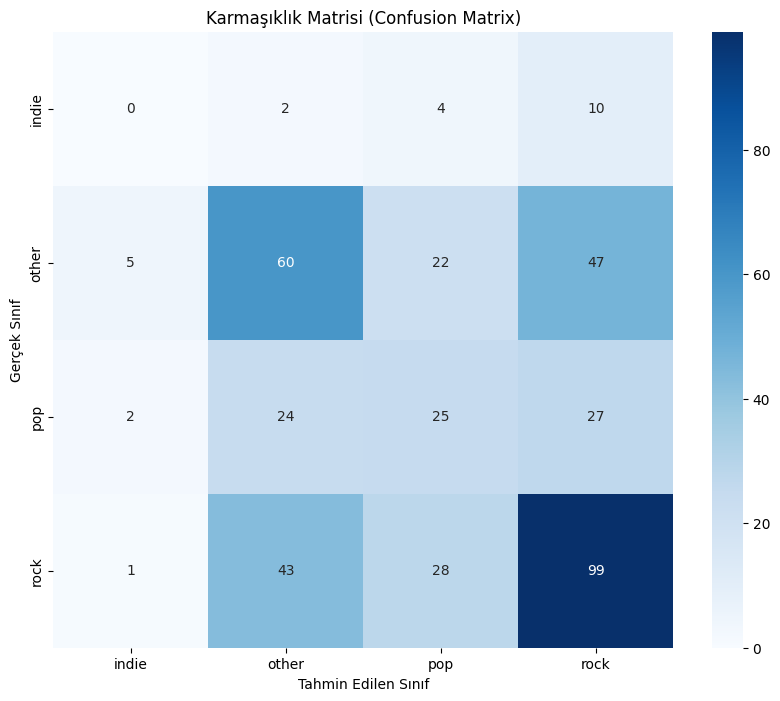

In [42]:
best_model = grid_search.best_estimator_

# En iyi model ile test seti üzerinde tahmin yap
y_pred_best = best_model.predict(X_test)

# Sonuçları Classification Report ile detaylı olarak yazdır
print("\nOPTİMİZE EDİLMİŞ MODELİN PERFORMANS RAPORU:")
print(classification_report(y_test, y_pred_best))

# Karmaşıklık Matrisi (Confusion Matrix) ile hata analizi yap
print("Karmaşıklık Matrisi oluşturuluyor...")
cm = confusion_matrix(y_test, y_pred_best, labels=best_model.classes_)

# Matrisi görselleştir
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.title('Karmaşıklık Matrisi (Confusion Matrix)')
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.show()